# Statistical Learning Project - COMP 8590

Team members:

*   Delaram Rajaei 110124422
*   Farinam Hemmatizadeh 110106214

All the imports that are used in the project.

In [1]:
!pip install nltk faker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.2 MB/s eta 0:00:00


In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.3 MB/s eta 0:00:00


In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import metrics

import string


from faker import Faker
import random

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Preprocessing Data

In this section, we begin by either generating the necessary data or utilizing the *BuzzFeedNews* dataset. Following that, we move on to preprocessing the data and dividing it into separate test and train sets.

In [4]:
model = AutoModelForSeq2SeqLM.from_pretrained('facebook/nllb-200-distilled-600M')
tokenizer = AutoTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')
translator = pipeline("translation", model=model, tokenizer=tokenizer, src_lang='eng_Latn', tgt_lang='fra_Latn', max_length=512)
back_translator = pipeline("translation", model=model, tokenizer=tokenizer, src_lang='fra_Latn', tgt_lang='eng_Latn', max_length=512)

def data_augmentation(text):
  translated_query = translator(text)
  back_translated_query = back_translator(translated_query[0]['translation_text'])
  return back_translated_query[0]['translation_text']

In [5]:
def generate_text_with_word(target_word, text_length):
    # Make sure the target word is lowercase to simplify matching
    target_word = target_word.lower()

    # Remove any punctuation from the target word
    target_word = target_word.translate(str.maketrans('', '', string.punctuation))

    # The text length should be at least the length of the target word
    if text_length < len(target_word):
        raise ValueError("Text length should be greater than or equal to the target word's length.")

    # Generate random text of the desired length
    text = ""
    current_length = 0
    while current_length < text_length:
        # Generate random words (6-10 characters) to fill the text
        random_word = ''.join(random.choices(string.ascii_lowercase, k=random.randint(6, 10)))
        text += random_word + " "
        current_length += len(random_word) + 1  # +1 to account for the space

    # Replace a random word with the target word
    words = text.strip().split()
    random_index = random.randint(0, len(words) - 1)
    words[random_index] = target_word

    # Recreate the text with the target word included
    text_with_target = ' '.join(words)

    return text_with_target

def generate_fake_line(data: dict, words: list, polarity):
  fake = Faker()

  random_index = random.randint(0, len(words) - 1)
  text = fake.text(ext_word_list=list(words[random_index]))
  # text = generate_text_with_word(words[random_index], 50)
  category = random.choice(['A', 'B', 'C'])

  # backtranslated_text = data_augmentation(text)
  # data['Name'].extend([text, backtranslated_text])
  # data['Category'].extend([category, category])
  # data['Polarity'].extend([polarity, polarity])

  data['News'].extend([text])
  data['Category'].extend([category])
  data['Polarity'].extend([polarity])

  return data

def generate_dataset():
  num_samples = 500

  data= {
    'News': [],
    'Category': [],
    'Polarity': []
  }

  positive_words = ["good", "excellent", "wonderful", "amazing", "fantastic", "joy", "delight", "happy", "love", "pleasure"]
  negative_words = ["bad", "poor", "terrible", "awful", "disappointing", "sad", "unfortunate", "hate", "pain", "disgust"]


  for _ in range(num_samples):
    data = generate_fake_line(data, positive_words, 1)
    data = generate_fake_line(data, negative_words, -1)

  return pd.DataFrame(data)

In [12]:
def plot_category_by_rating(dataframe, category_column, polarity_column, name):

    categories = list(dataframe[category_column].unique())
    polarity = list(dataframe[polarity_column].unique())

    data = dict()
    for each_polarity in polarity:
      data[each_polarity] = dict()
      for each_class in categories:
        data[each_polarity][each_class] = len(dataframe[(dataframe[category_column] == each_class) & (dataframe[polarity_column] == each_polarity)])

    colors = ['#b366ff', '#3399ff', '#00e673', '#ffcc00', '#ff751a']
    bar_width = 0.2

    # Calculate the position of each bar on the x-axis
    bar_positions = np.arange(len(categories))

    # Plotting the bars separately for each category
    for i, p in enumerate(polarity):
        values = [data[p][category] for category in categories]
        bars = plt.bar(bar_positions + (i * bar_width), values, color=colors[i], alpha=0.8, width=bar_width, label=p)

        # Adding value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

    plt.xlabel('Categories')
    plt.ylabel('Number of Articles')
    plt.title(name)
    plt.xticks(bar_positions + bar_width * (len(polarity) / 2 - 0.5), categories)
    plt.legend()
    plt.show()

In [10]:
# get data
def get_dataset(corpus_name: str):
  if corpus_name == 'Fake':
    dataset = generate_dataset()
    name = 'Fake Generated Dataset'
  elif corpus_name == 'MovieReview':
    csv_file_path = "./movie_review.csv"
    dataset = pd.read_csv(csv_file_path)
    name = 'Movie Review Dataset'
  elif corpus_name == 'FakeNewsNet':
    csv_files = ['gossipcop_fake', 'gossipcop_real', 'politifact_fake', 'politifact_real']
    dfs = []
    for file in csv_files:
        data = pd.read_csv('./' + file + '.csv')
        titles = data['title']
        # category = "G" if file.split('_')[0] == "gossipcop" else "P"
        category = "N"
        polarity = 1 if file.split('_')[1] == 'real' else -1
        count = 0
        for title in titles:
            # if count > 1000 : break
            dfs.append(pd.DataFrame({'News': [title], 'Category': [category], 'Polarity': [polarity]}))
            count += 1
    dataset = pd.concat(dfs, ignore_index=True)
    name = 'Fake News Net Dataset'
  else:
      print(f'This {corpus_name} cannot be found! Please choose between the available datasets.')

  plot_category_by_rating(dataset, 'Category', 'Polarity', name)
  return dataset

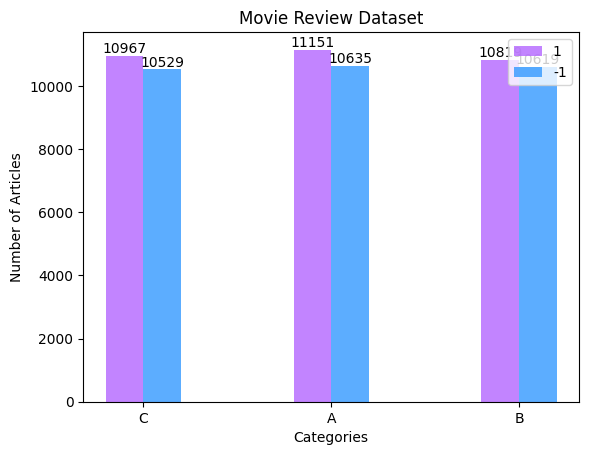

,News,Category,Polarity
0,films adapted from comic books have had plenty...,C,1
1,"for starters , it was created by alan moore ( ...",C,1
2,to say moore and campbell thoroughly researche...,A,1
3,"the book ( or "" graphic novel , "" if you will ...",B,1
4,"in other words , don't dismiss this film becau...",B,1


In [13]:
dataset_movie = get_dataset('MovieReview')
dataset_movie.head()

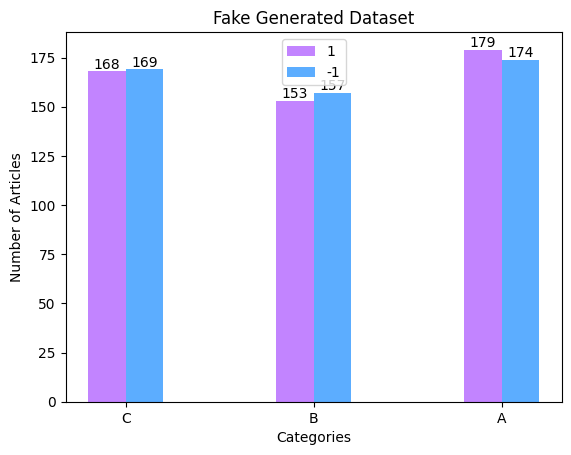

,News,Category,Polarity
0,O o o y. J j o o.\nO j j y. O j o y. J j j o y...,C,1
1,R o u u o t a. A u t o u. N o r u.\nU u r n f ...,B,-1
2,E e l p e u p. S s u p.\nL l r e. A l a e u l....,A,1
3,O p i n d. G s g i i a.\nN i a t. P n i a. P d...,B,-1
4,T l g l. H d g i.\nD h t h e e. D l i h t t i ...,C,1


In [14]:
dataset_fake = get_dataset('Fake')
dataset_fake.head()

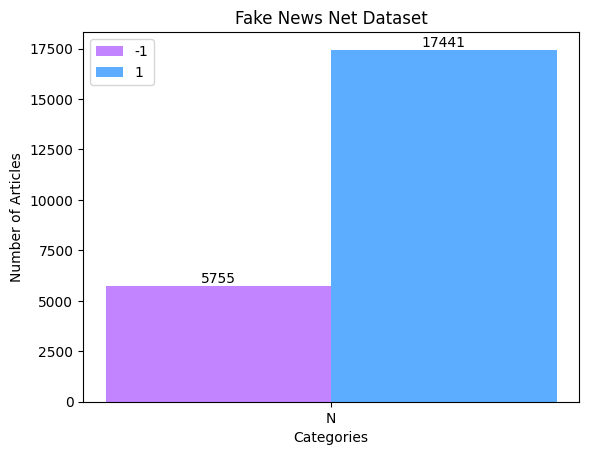

,News,Category,Polarity
0,Did Miley Cyrus and Liam Hemsworth secretly ge...,N,-1
1,Paris Jackson & Cara Delevingne Enjoy Night Ou...,N,-1
2,Celebrities Join Tax March in Protest of Donal...,N,-1
3,Cindy Crawford's daughter Kaia Gerber wears a ...,N,-1
4,Full List of 2018 Oscar Nominations – Variety,N,-1


In [15]:
dataset_net = get_dataset('FakeNewsNet')
dataset_net.head()

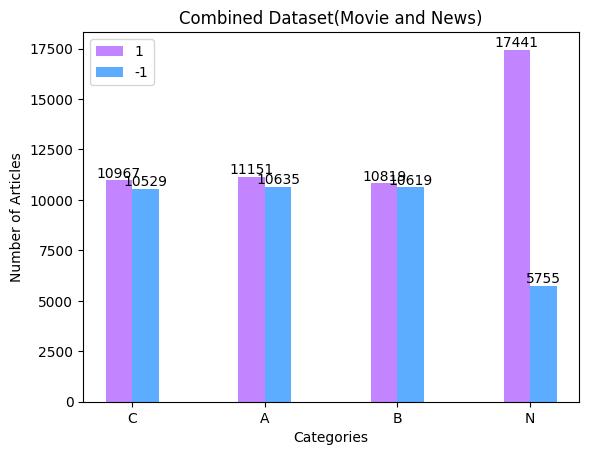

,News,Category,Polarity
0,films adapted from comic books have had plenty...,C,1
1,"for starters , it was created by alan moore ( ...",C,1
2,to say moore and campbell thoroughly researche...,A,1
3,"the book ( or "" graphic novel , "" if you will ...",B,1
4,"in other words , don't dismiss this film becau...",B,1


In [17]:
# Merge the two datasets
df = pd.concat([dataset_movie, dataset_net], ignore_index=True)

# Optionally, you can reset the index if needed
df.reset_index(drop=True, inplace=True)

plot_category_by_rating(df, 'Category', 'Polarity', 'Combined Dataset(Movie and News)')
df.head()

In [18]:
def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Tokenization
    tokens = nltk.word_tokenize(text)

    # Punctuation removal
    tokens = [token for token in tokens if token not in string.punctuation]

    # Stopwords removal
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    return ' '.join(tokens)


In [19]:
# preprocessing for the training set
preprocessed_news_movie = [preprocess_text(news) for news in dataset_movie['News']]
preprocessed_news_net = [preprocess_text(news) for news in dataset_net['News']]
preprocessed_news_fake = [preprocess_text(news) for news in df['News']]

In [20]:
# Vectorize preprocessed news
vectorizer = CountVectorizer()
news_vect_movie = vectorizer.fit_transform(preprocessed_news_movie)
news_vect_net = vectorizer.fit_transform(preprocessed_news_net)
news_vect_fake = vectorizer.fit_transform(preprocessed_news_fake)

In [21]:
# Split the dataset
news_train_vect_movie, news_test_vect_movie, polarity_train_movie, polarity_test_movie = train_test_split(news_vect_movie, dataset_movie['Polarity'], test_size=0.2, random_state=0)
news_train_vect_net, news_test_vect_net, polarity_train_net, polarity_test_net = train_test_split(news_vect_net, dataset_net['Polarity'], test_size=0.2, random_state=0)
news_train_vect_fake, news_test_vect_fake, polarity_train_fake, polarity_test_fake = train_test_split(news_vect_fake, df['Polarity'], test_size=0.2, random_state=0)

## Training Models

In [22]:
class NaiveBayes:
    def __init__(self, name: str):
        self.name = name
        self.model = MultinomialNB() if name=='multinomial' else BernoulliNB()

    def get_model(self):
      return self.model

    def train(self, train_set, label_train_set, text, cv=5, batch_size=100):
      self.model.fit(train_set, label_train_set)
      # Perform k-fold cross-validation
      scores = cross_val_score(self.model, train_set, label_train_set, cv=cv)

      # Calculate the mean and standard deviation of the cross-validation scores
      mean_score = np.mean(scores)
      std_score = np.std(scores)

      # Print the results
      print(f"\n{self.name} scores (train - {text}): {scores}\n")
      print(f"Mean accuracy (train - {text}): {mean_score:.4f} (+/- {std_score:.4f})\n")

      # Plot the cross-validation scores
      plt.figure()
      plt.plot(range(1, cv+1), scores, marker='o')
      plt.xlabel('Fold number')
      plt.ylabel('Accuracy')
      plt.title(f'Cross-Validation Scores for {self.name} model and {text}')
      plt.xticks(range(1, cv+1))
      plt.grid(True)
      plt.show()

    def test(self, test_set, label_test_set, text):
      score_test = self.model.score(test_set, label_test_set)
      print(f"{self.name} score (test - {text}): {score_test}")

    def compare_models(self, model1, model2, test_set, label_test):
      predict1 = model1.model.predict(test_set)
      predict2 = model2.model.predict(test_set)

      label = [model1.name, model2.name]
      index = np.arange(len(label))

      accuracy1 = (accuracy_score(label_test, predict1) * 100)
      accuracy2 = (accuracy_score(label_test, predict2) * 100)
      index = np.arange(len(label))
      accuracies = [accuracy1, accuracy2]

      # Create a figure and axis
      fig, ax = plt.subplots()

      # Plot the accuracies in a bar chart
      bars = ax.bar([model1.name, model2.name], accuracies, color=['#1f77b4', '#ff7f0e'])

      # Add text labels on top of the bars
      for bar in bars:
          height = bar.get_height()
          ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom')

      # Add labels and title
      ax.set_ylabel('Accuracy')
      ax.set_title('Accuracy Comparison between Multinomial Model and Bernoulli Model')

      # Show the plot
      plt.show()

      fprb, tprb, thresholdsb = metrics.roc_curve (label_test, predict1, pos_label=1)
      fprm, tprm, thresholdsm = metrics.roc_curve (label_test, predict2, pos_label=1)
      plt.plot(fprm, tprm, label= model1.name)
      plt.plot(fprb, tprb, label= model2.name)
      plt.legend()
      plt.xlabel('False positive rate')
      plt.ylabel('True positive rate')
      plt.show()

In [23]:
# Initialize models
multinomial_model_movie = NaiveBayes('multinomial')
bernoulli_model_movie = NaiveBayes('bernoulli')

multinomial_model_net = NaiveBayes('multinomial')
bernoulli_model_net = NaiveBayes('bernoulli')

multinomial_model_fake = NaiveBayes('multinomial')
bernoulli_model_fake = NaiveBayes('bernoulli')


multinomial scores (train - Movie Review dataset): [0.696601   0.69985514 0.69734428 0.71086432 0.69744085]

Mean accuracy (train - Movie Review dataset): 0.7004 (+/- 0.0053)



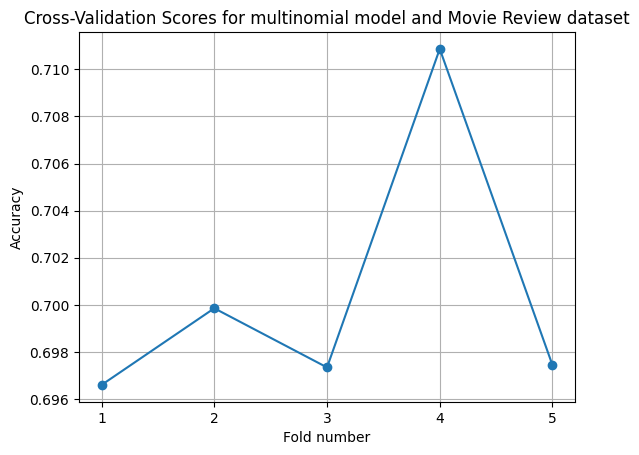


bernoulli scores (train - Movie Review dataset): [0.69524913 0.70217286 0.69995171 0.70912603 0.6965717 ]

Mean accuracy (train - Movie Review dataset): 0.7006 (+/- 0.0049)



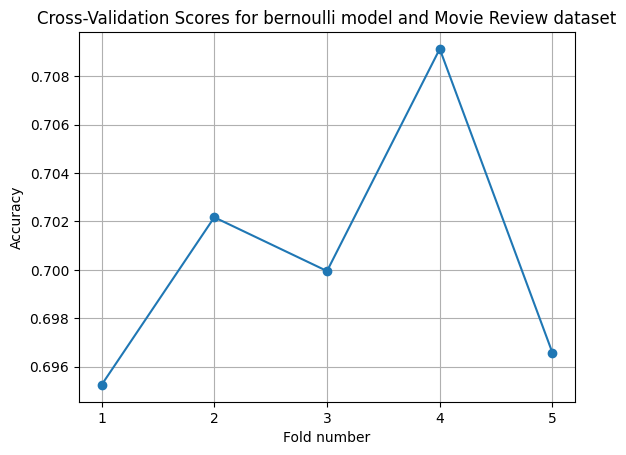


multinomial scores (train - FakeNewsNet dataset): [0.83162716 0.81729992 0.8296955  0.8191862  0.83535435]

Mean accuracy (train - FakeNewsNet dataset): 0.8266 (+/- 0.0071)



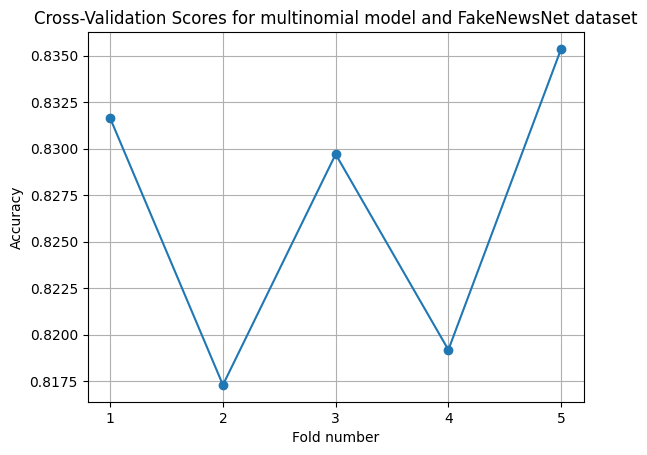


bernoulli scores (train - FakeNewsNet dataset): [0.83001078 0.81864726 0.83265966 0.82457559 0.84209108]

Mean accuracy (train - FakeNewsNet dataset): 0.8296 (+/- 0.0079)



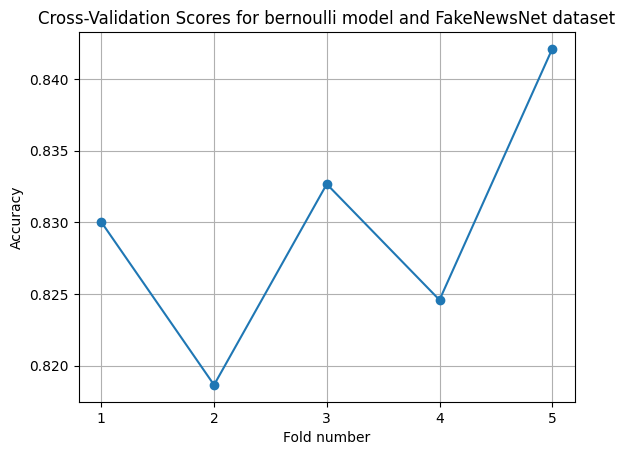


multinomial scores (train - Fake dataset): [0.71067036 0.71955641 0.71569743 0.70460685 0.71029433]

Mean accuracy (train - Fake dataset): 0.7122 (+/- 0.0051)



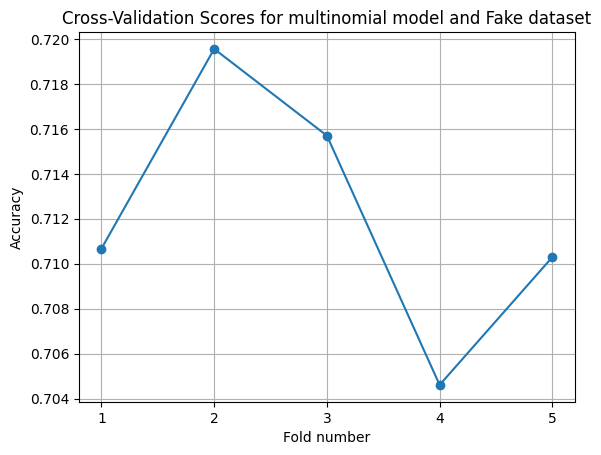


bernoulli scores (train - Fake dataset): [0.70725812 0.71550437 0.70958339 0.70218968 0.71000995]

Mean accuracy (train - Fake dataset): 0.7089 (+/- 0.0043)



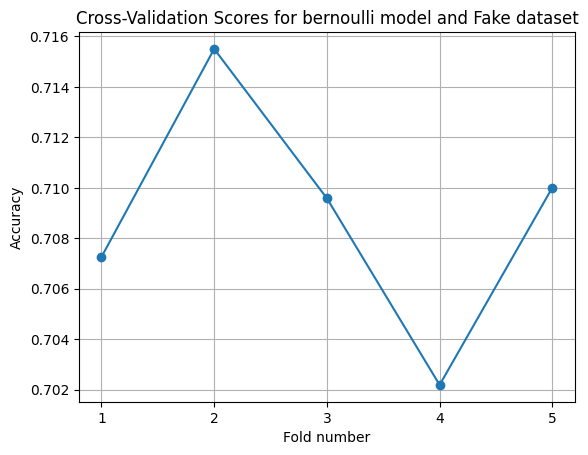

In [24]:
# Train
# Movie Review dataset
multinomial_model_movie.train(news_train_vect_movie, polarity_train_movie, 'Movie Review dataset')
bernoulli_model_movie.train(news_train_vect_movie, polarity_train_movie, 'Movie Review dataset')

# FakeNewsNet dataset
multinomial_model_net.train(news_train_vect_net, polarity_train_net, 'FakeNewsNet dataset')
bernoulli_model_net.train(news_train_vect_net, polarity_train_net, 'FakeNewsNet dataset')

# Fake dataset
multinomial_model_fake.train(news_train_vect_fake, polarity_train_fake, 'Fake dataset')
bernoulli_model_fake.train(news_train_vect_fake, polarity_train_fake, 'Fake dataset')

## Predincting New Data

In [25]:
multinomial_model_net.test(news_test_vect_net, polarity_test_net, 'FakeNewsNet dataset')
bernoulli_model_net.test(news_test_vect_net, polarity_test_net, 'FakeNewsNet dataset')

multinomial score (test - FakeNewsNet dataset): 0.8243534482758621
bernoulli score (test - FakeNewsNet dataset): 0.8290948275862069


In [26]:
multinomial_model_movie.test(news_test_vect_movie, polarity_test_movie, 'Movie Review dataset')
bernoulli_model_movie.test(news_test_vect_movie, polarity_test_movie, 'Movie Review dataset')

multinomial score (test - Movie Review dataset): 0.7027966625463535
bernoulli score (test - Movie Review dataset): 0.7037237330037083


In [27]:
multinomial_model_fake.test(news_test_vect_fake, polarity_test_fake, 'Fake dataset')
bernoulli_model_fake.test(news_test_vect_fake, polarity_test_fake, 'Fake dataset')

multinomial score (test - Fake dataset): 0.715934940855323
bernoulli score (test - Fake dataset): 0.7121246587807097


## Accuracy Comparison

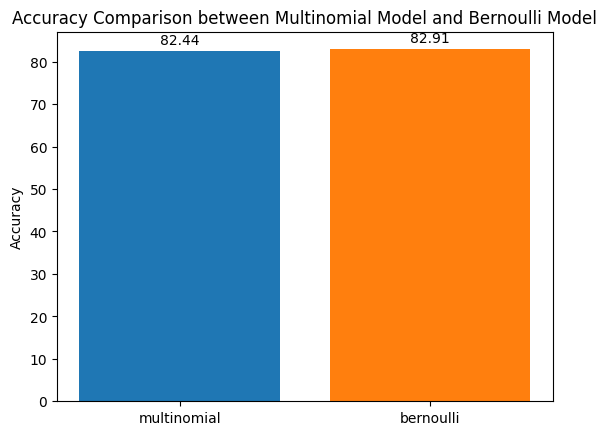

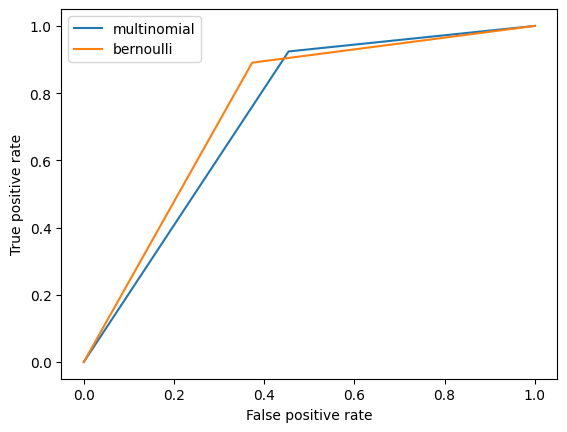

In [28]:
multinomial_model_net.compare_models(multinomial_model_net, bernoulli_model_net, news_test_vect_net, polarity_test_net)

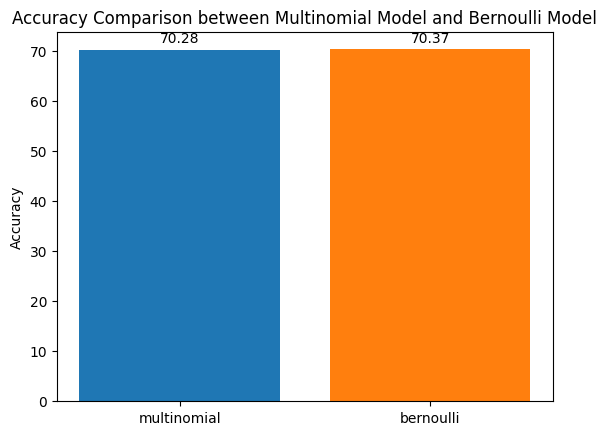

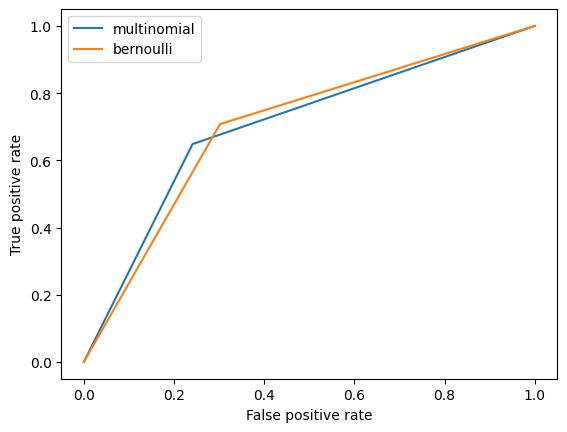

In [29]:
multinomial_model_movie.compare_models(multinomial_model_movie, bernoulli_model_movie, news_test_vect_movie, polarity_test_movie)

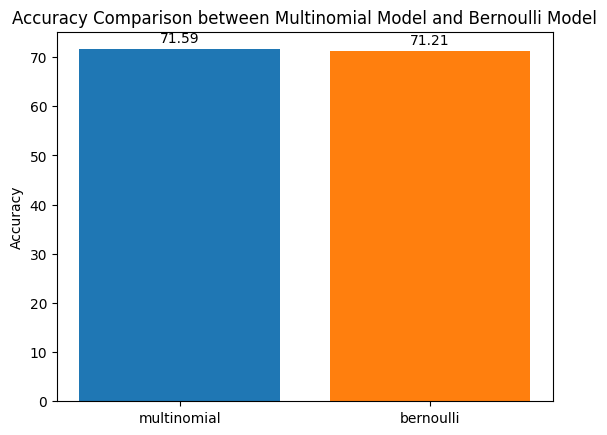

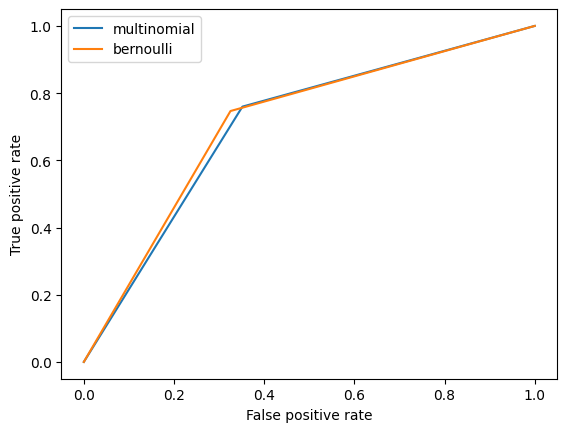

In [30]:
multinomial_model_fake.compare_models(multinomial_model_fake, bernoulli_model_fake, news_test_vect_fake, polarity_test_fake)